In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import (mean_squared_error, mean_absolute_error)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRFRegressor

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 4
rcParams['lines.linewidth'] = 1
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'

## Load dataset

In [3]:
df_train = pd.read_csv('train-data.csv')

df_train.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


## Data Null

In [4]:
b_cleansing = df_train.copy()

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


In [6]:
df_train.isna().sum()

Unnamed: 0              0
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

- Kolom "New_Price" dihapus karena banyak memiliki data null
- baris yang memiliki data kosong dihapus

In [7]:
df_train.drop(['New_Price','Unnamed: 0'], axis=1, inplace=True)
df_train = df_train.dropna()
df_train = df_train.reset_index(drop=True)

df_train.isna().sum()

Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
dtype: int64

## Pengelompokan data

Mengganti kolom yang terbaca sebagai object untuk menjadi numerical
- "Mileage"
- "Engine"
- "Power"

In [8]:
numericals = ['Year', 'Kilometers_Driven',  'Seats', 'Price' ]
categoricals = ['Name', 'Location','Fuel_Type','Transmission' , 'Owner_Type', 'Mileage', 'Engine' ,'Power']

In [9]:
for i in range(len(df_train)):
    df_train.at[i, 'Brand'] = df_train['Name'][i].split()[0].capitalize()
    df_train.at[i, 'Mileage(km/kg)'] = df_train['Mileage'][i].split()[0]
    df_train.at[i, 'Engine(CC)'] = df_train['Engine'][i].split()[0]
    df_train.at[i, 'Power(bhp)'] = df_train['Power'][i].split()[0]


In [10]:
#menghapus kata-kata "null" yang ada dalam kolom

position = []
for i in range(len(df_train)):
    if df_train['Power(bhp)'][i]=='null':
        position.append(i)

df_train = df_train.drop(df_train.index[position])
df_train = df_train.reset_index(drop=True)

In [11]:
#ubah data menjadi float / numerical

df_train['Mileage(km/kg)'] = df_train['Mileage(km/kg)'].astype(float)
df_train['Engine(CC)'] = df_train['Engine(CC)'].astype(float)
df_train['Power(bhp)'] = df_train['Power(bhp)'].astype(float)

#Menghapus kolom lama karena sudah diganti
df_train.drop(['Name','Mileage','Engine','Power'], axis=1, inplace=True)

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5872 entries, 0 to 5871
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           5872 non-null   object 
 1   Year               5872 non-null   int64  
 2   Kilometers_Driven  5872 non-null   int64  
 3   Fuel_Type          5872 non-null   object 
 4   Transmission       5872 non-null   object 
 5   Owner_Type         5872 non-null   object 
 6   Seats              5872 non-null   float64
 7   Price              5872 non-null   float64
 8   Brand              5872 non-null   object 
 9   Mileage(km/kg)     5872 non-null   float64
 10  Engine(CC)         5872 non-null   float64
 11  Power(bhp)         5872 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 550.6+ KB


In [13]:
b_class = df_train.copy()

Klasifikasi data agar menjadi saat dibuat pemodelan memiliki kolom yang lebih sedikit
- "Owner_Type" menjadi 3 unique data ("First", "Second", "Third>")
- "Brand" menjadi data negara pembuat (co : "Maruti" menjadi "India")
- "Year" menjadi "Age" (co: 2015 menjadi 5, 2019 menjadi 1 )

In [14]:
#klasifikasi data Brand berdasarkan negara

India = ['Maruti','Tata', 'Mahindra', 'Ambassador', 'Force']
Jepang =  ['Honda','Nissan', 'Toyota', 'Mitsubishi', 'Datsun', 'Isuzu' ]
Jerman = ['Audi', 'Volkswagen', 'Mercedes-benz', 'Bmw', 'Porsche'] 
Inggris = ['Land', 'Jaguar', 'Mini', 'Bentley']
Amerika = ['Ford', 'Chevrolet','Jeep']
Eropa = ['Renault', 'Volvo', 'Skoda', 'Fiat', 'Lamborghini']
Asia = ['Hyundai']

Car_negara = []

for kolom in df_train['Brand']:
    if kolom in India:
        Car_negara.append("India")
    elif kolom in Jepang:
        Car_negara.append("Jepang")
    elif kolom in Jerman:
        Car_negara.append("Jerman")
    elif kolom in Inggris:
        Car_negara.append("Inggris")
    elif kolom in Amerika:
        Car_negara.append("Amerika")
    elif kolom in Eropa:
        Car_negara.append("Eropa")
    else:
        Car_negara.append("Asia")
        
df_train['car_negara'] = Car_negara

In [15]:
#klasifikasi Owner_Type

owner_type = []

for kolom in df_train['Owner_Type']:
    if kolom in 'First':
        owner_type.append("First")
    elif kolom in 'Second':
        owner_type.append("Second")
    else:
        owner_type.append("Third>")
        
df_train['owner_type'] = owner_type  

In [16]:
# Year menjadi Age

Age = []

for umur in df_train['Year']:
    Age.append(2020 - umur)
    
df_train['Age'] = Age

In [17]:
#Seats menjadi non 2 seat

Seat = []

for kolom in df_train['Seats']:
    if kolom == 2 :
        Seat.append(1)
    else:
        Seat.append(0)
        
df_train['two_seats'] = Seat  

In [18]:
#counts

itungan = []

for x in range(len(df_train)):
    itungan.append(1)
    
df_train['itungan'] = itungan

In [19]:
b_viz = df_train.copy()

In [20]:
b_viz.to_csv(r'untuk_visualisasi.csv', index = False)

## Visualisasi untuk Insight

In [21]:
b_viz

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price,Brand,Mileage(km/kg),Engine(CC),Power(bhp),car_negara,owner_type,Age,two_seats,itungan
0,Mumbai,2010,72000,CNG,Manual,First,5.0,1.75,Maruti,26.60,998.0,58.16,India,First,10,0,1
1,Pune,2015,41000,Diesel,Manual,First,5.0,12.50,Hyundai,19.67,1582.0,126.20,Asia,First,5,0,1
2,Chennai,2011,46000,Petrol,Manual,First,5.0,4.50,Honda,18.20,1199.0,88.70,Jepang,First,9,0,1
3,Chennai,2012,87000,Diesel,Manual,First,7.0,6.00,Maruti,20.77,1248.0,88.76,India,First,8,0,1
4,Coimbatore,2013,40670,Diesel,Automatic,Second,5.0,17.74,Audi,15.20,1968.0,140.80,Jerman,Second,7,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5867,Delhi,2014,27365,Diesel,Manual,First,5.0,4.75,Maruti,28.40,1248.0,74.00,India,First,6,0,1
5868,Jaipur,2015,100000,Diesel,Manual,First,5.0,4.00,Hyundai,24.40,1120.0,71.00,Asia,First,5,0,1
5869,Jaipur,2012,55000,Diesel,Manual,Second,8.0,2.90,Mahindra,14.00,2498.0,112.00,India,Second,8,0,1
5870,Kolkata,2013,46000,Petrol,Manual,First,5.0,2.65,Maruti,18.90,998.0,67.10,India,First,7,0,1


### Brand Insight

In [27]:
b_viz

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price,Brand,Mileage(km/kg),Engine(CC),Power(bhp),car_negara,owner_type,Age,two_seats,itungan
1667,Pune,2011,65000,Petrol,Manual,Second,4.0,0.44,Tata,26.00,624.0,35.0,India,Second,9,0,1
1584,Jaipur,2004,12000,Petrol,Manual,Second,4.0,0.45,Maruti,16.10,796.0,37.0,India,Second,16,0,1
3055,Jaipur,1998,95150,Petrol,Manual,Third,5.0,0.45,Maruti,17.30,993.0,60.0,India,Third>,22,0,1
2768,Pune,2005,86000,Petrol,Manual,Second,5.0,0.45,Hyundai,15.30,1341.0,83.0,Asia,Second,15,0,1
3144,Pune,2003,52000,Petrol,Manual,First,4.0,0.50,Maruti,16.10,796.0,37.0,India,First,17,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1926,Coimbatore,2018,28060,Petrol,Automatic,First,5.0,93.67,Bmw,12.05,2979.0,320.0,Jerman,First,2,0,1
1463,Kochi,2019,26013,Diesel,Automatic,First,5.0,97.07,Land,12.65,2993.0,255.0,Inggris,First,1,0,1
5775,Hyderabad,2015,8000,Petrol,Automatic,First,2.0,100.00,Jaguar,12.50,5000.0,488.1,Inggris,First,5,1,1
5640,Delhi,2011,6500,Petrol,Automatic,Third,2.0,120.00,Lamborghini,6.40,5204.0,560.0,Eropa,Third>,9,1,1


#### brand (negara) vs location (bar chart stacked)

<Figure size 7200x2880 with 0 Axes>

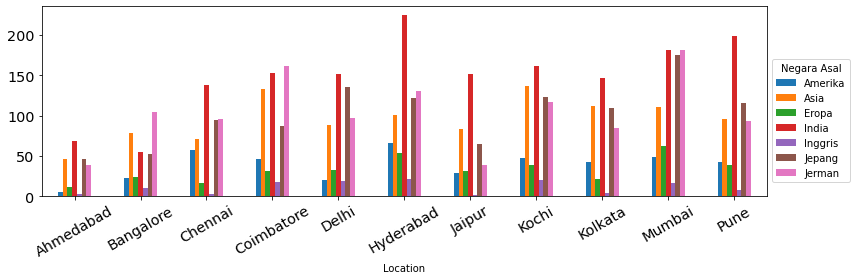

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize = (100, 40))
b_viz.groupby(['Location','car_negara'])['itungan'].sum().unstack().plot(kind='bar')
plt.title('', loc='center',pad=30,fontsize=15,color='blue')

plt.legend(bbox_to_anchor=(1,0.75), title='Negara Asal')
plt.ylim(ymin=0)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

coba liat lebih detail tentang Bangalore, Coimbatore, Mumbai yang kepemilikan mobilnya terlihat sama atau lebih besar

dan kenapa mobil jerman bukan mobil lain??

<Figure size 72x72 with 0 Axes>

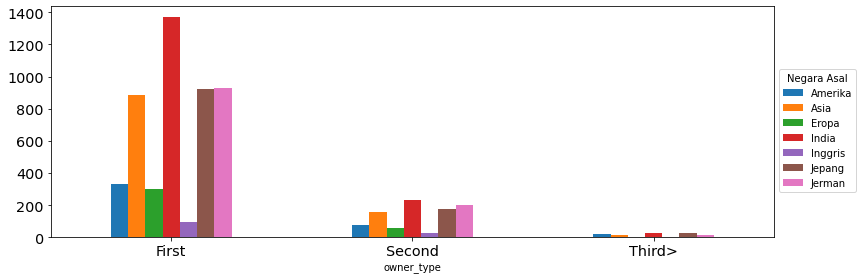

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize = (1, 1))
b_viz.groupby(['owner_type','car_negara'])['itungan'].sum().unstack().plot(kind='bar')
plt.title('', loc='center',pad=30,fontsize=15,color='blue')

plt.legend(bbox_to_anchor=(1.12,0.75), title='Negara Asal')
plt.ylim(ymin=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### two_seats

<Figure size 360x360 with 0 Axes>

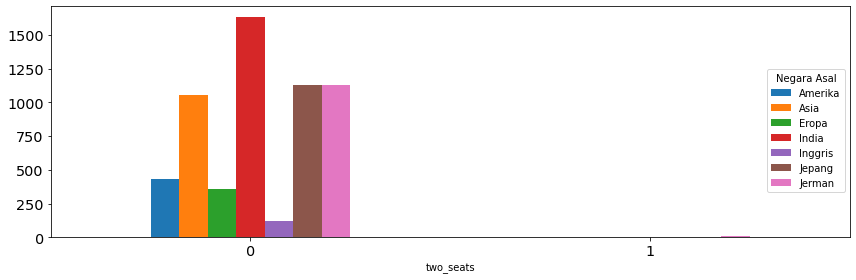

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize = (5, 5))
b_viz.groupby(['two_seats','car_negara'])['itungan'].sum().unstack().plot(kind='bar')
plt.title('', loc='center',pad=30,fontsize=15,color='blue')

plt.legend(bbox_to_anchor=(1,0.75), title='Negara Asal')
plt.ylim(ymin=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

bikin harga nya non two seats  dan seats

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

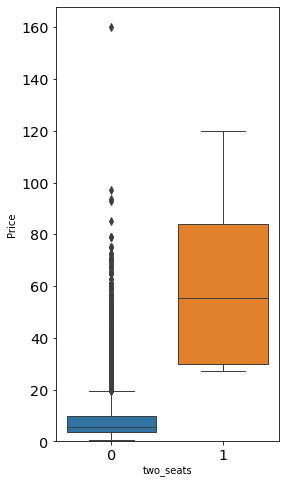

In [90]:
var = 'two_seats'
data = pd.concat([b_viz['Price'], b_viz[var]], axis=1)
f, ax = plt.subplots(figsize=(4, 8))
fig = sns.boxplot(x=var, y="Price", data=data)
fig.axis(ymin=0);
plt.xticks(rotation=0)

harga mobil per negara, bukan countplot

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

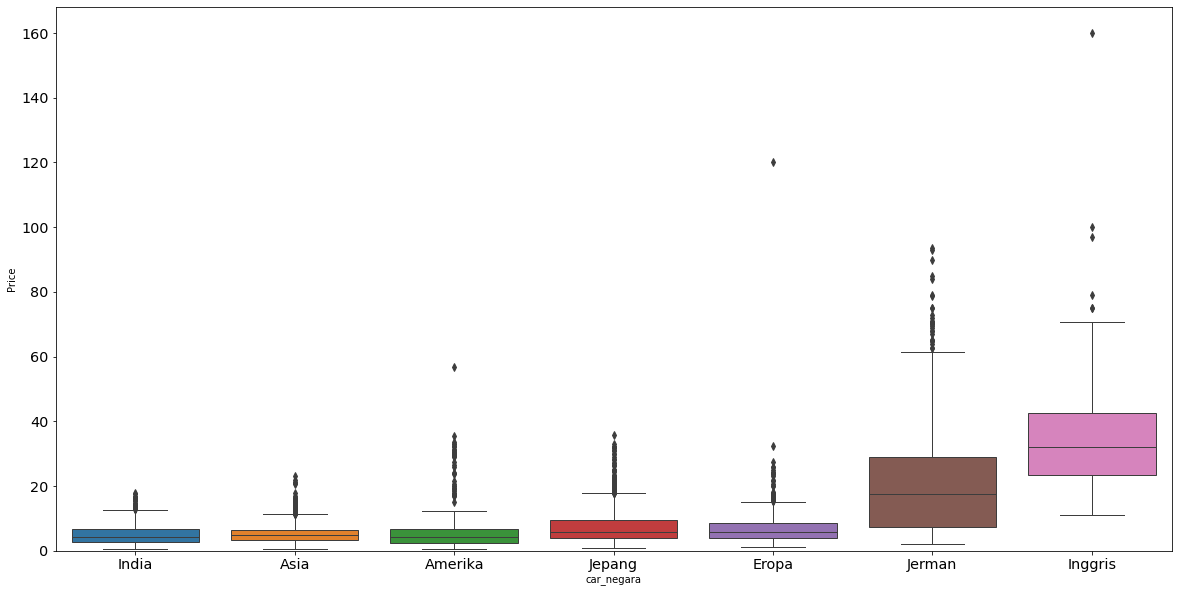

In [84]:
var = 'car_negara'
data = pd.concat([b_viz['Price'], b_viz[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x=var, y="Price", data=data)
fig.axis(ymin=0);
plt.xticks(rotation=0)

Age vs Price

Text(0.5, 1.0, 'Prices vs Age')

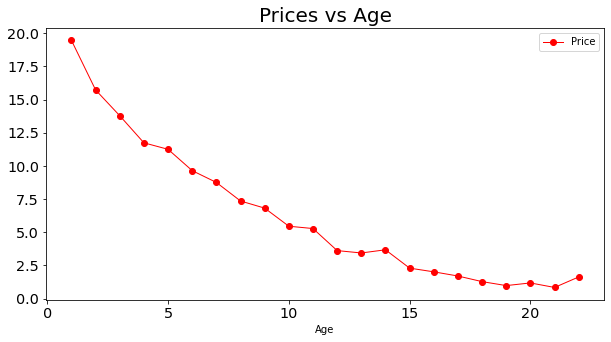

In [91]:
axis = b_viz.groupby('Age')[['Price']].mean().plot(figsize=(10,5),marker='o',color='r')
plt.title("Prices vs Age", fontsize=20,ha='center')

## Untuk insight ML

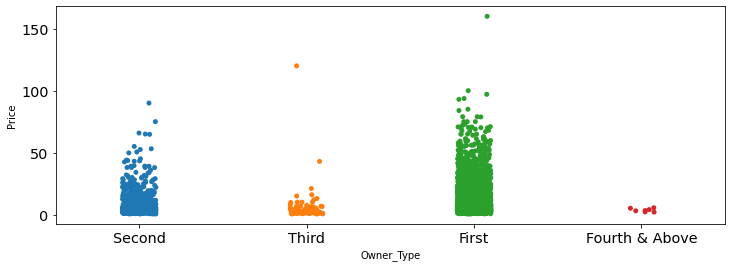

In [100]:
#before

var = 'Owner_Type'
fig, ax = plt.subplots()

sns.stripplot(x = var, y ='Price', data = b_viz) 

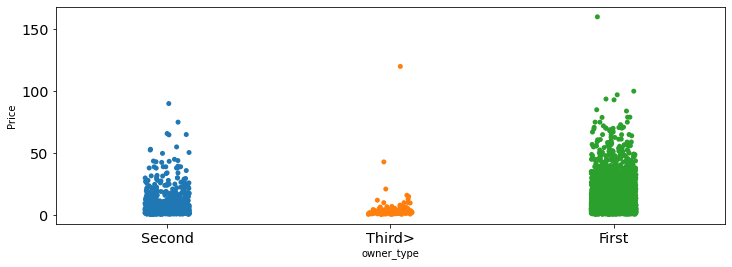

In [102]:
#after

var = 'owner_type'
fig, ax = plt.subplots()

sns.stripplot(x = var, y ='Price', data = b_viz) 

## Pre Processing Untuk Machine Learning

### Feature Encoding

In [ ]:
df_train

drop "Owner_Type" dan "Brand" karena sudah digantikan

In [ ]:
df_train.drop(["Brand"],axis=1,inplace=True)
df_train.drop(["Owner_Type"],axis=1,inplace=True)
df_train.drop(['itungan'],axis=1,inplace=True)

drop "Location"

In [ ]:
df_train.drop(["Location"],axis=1,inplace=True)

Fuel_Type

In [ ]:
Fuel_t = df_train[['Fuel_Type']]
Fuel_t = pd.get_dummies(Fuel_t,drop_first=True)

Fuel_t.head()

Transmission

In [ ]:
Transmission = df_train[["Transmission"]]
Transmission = pd.get_dummies(Transmission,drop_first=True)

Transmission.head()

car_negara

In [ ]:
Location = df_train[["car_negara"]]
Location = pd.get_dummies(Location,drop_first=True)

Location.head()

owner_type

In [ ]:
df_train.replace({"First":1,"Second":2,"Third>": 3},inplace=True)

df_train.head()

Gabungkan encoding dan hapus yang lama

In [ ]:
df_train.drop(["Fuel_Type"],axis=1,inplace=True)
df_train.drop(["Transmission"],axis=1,inplace=True)
df_train.drop(["car_negara"],axis=1,inplace=True)
df_train.drop(["Year"],axis=1,inplace=True)
df_train.drop(["Seats"],axis=1,inplace=True)

In [ ]:
final_train= pd.concat([df_train,Location,Fuel_t,Transmission],axis=1)

final_train.head()

### Standarisasi

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

final_train['Age'] = StandardScaler().fit_transform(final_train['Age'].values.reshape(len(final_train), 1))
final_train['Kilometers_Driven'] = StandardScaler().fit_transform(final_train['Kilometers_Driven'].values.reshape(len(final_train), 1))
final_train['Mileage(km/kg)'] = StandardScaler().fit_transform(final_train['Mileage(km/kg)'].values.reshape(len(final_train), 1))
final_train['Engine(CC)'] = StandardScaler().fit_transform(final_train['Engine(CC)'].values.reshape(len(final_train), 1))
final_train['Power(bhp)'] = StandardScaler().fit_transform(final_train['Power(bhp)'].values.reshape(len(final_train), 1))
final_train['Price'] = StandardScaler().fit_transform(final_train['Price'].values.reshape(len(final_train), 1))

### Memisahkan train dengan test

In [ ]:
x = final_train.loc[:,['Kilometers_Driven', 'Mileage(km/kg)', 'Engine(CC)',
       'Power(bhp)', 'owner_type', 'Age', 'two_seats', 'car_negara_Asia',
       'car_negara_Eropa', 'car_negara_India', 'car_negara_Inggris',
       'car_negara_Jepang', 'car_negara_Jerman', 'Fuel_Type_Diesel',
       'Fuel_Type_LPG', 'Fuel_Type_Petrol', 'Transmission_Manual']]

y = final_train.loc[:,['Price']]

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 24)

### Pemodelan

In [ ]:
#Linear Regresi

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
mae_lr = round(mean_squared_error(y_test, y_pred),5)

print("R squared on testing: ",lr.score(x_test,y_test))
print('Mean absolute error:', mae_lr)

In [ ]:
#Ridge

from sklearn.linear_model import Ridge
ridge = Ridge(alpha=2)
ridge.fit(x_train, y_train)
ridge_pred = ridge.predict(x_test)
score_ridge = round(r2_score(y_test, ridge_pred),4)
mae_ridge = round(mean_squared_error(y_test, ridge_pred),8)

print('R squared ridge on testing:', score_ridge)
print('Mean absolute error:', mae_ridge)

In [ ]:
#Lasso 

from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(x_train, y_train)
lasso_pred = lasso.predict(x_test)
score_lasso = round(r2_score(y_test, lasso_pred),2)
mae_lasso = round(mean_squared_error(y_test, lasso_pred),8)

print('R squared lasso on testing:', score_lasso)
print('Mean absolute error:', mae_lasso)

In [ ]:
# Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
score_rf = round(r2_score(y_test, rf_pred),4)
mae_rf = round(mean_squared_error(y_test, rf_pred),8)

print('Random Forest Score:', score_rf)
print('Mean absolute error:', mae_rf)